# RNN for time series

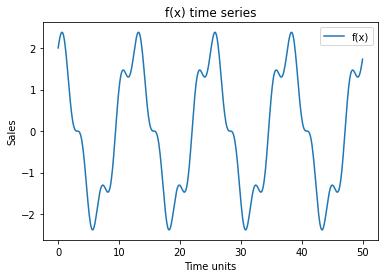

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def f(t): return .5*np.sin(2*t)+2*np.cos(.5*t)

x = np.linspace(0, 50, 500)
df = pd.DataFrame(f(x), index=x, columns = ["f(x)"])

df.plot(title = "f(x) time series", xlabel = "Time units", ylabel = "Sales");


## Train|test split

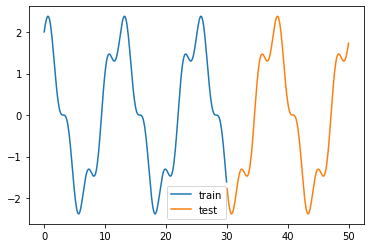

In [12]:
test_split = 200
df_train = df.iloc[:-test_split]
df_test = df.iloc[-test_split:]

ax = plt.axes()
df_train.plot(ax= ax)
df_test.plot(ax = ax)
plt.legend(["train", "test"]);

## Scale data

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

scaled_train.shape, scaled_test.shape, scaled_test.min(), scaled_test.max()

((300, 1), (200, 1), 0.00011292154516773234, 0.9994100860551354)

## Time series batches

format: (batch_size, time_steps, dimensionality)


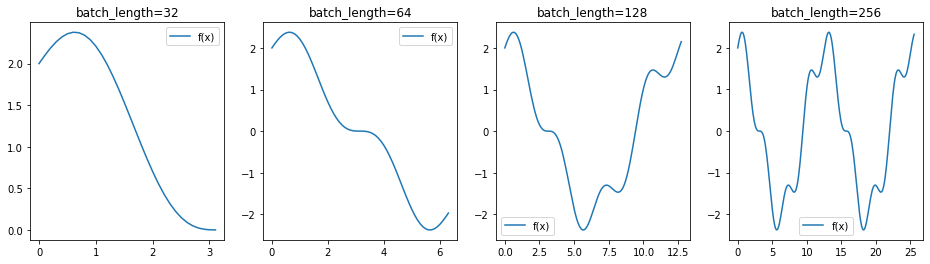

In [18]:
batch_lengths = [32, 64, 128, 256]

_, axes = plt.subplots(1,4, figsize = (16,4))

for batch_length, ax in zip(batch_lengths, axes):
    df_train.iloc[:batch_length].plot(ax = ax)
    ax.set_title(f"{batch_length=}")

In [33]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

batch_length, batch_size = 128, 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length = batch_length, batch_size = batch_size)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length = batch_length, batch_size = batch_size)


X, y = train_generator[0]
X.shape, y.shape

((1, 128, 1), (1, 1))

In [27]:
X[0, -3:, 0], scaled_train[batch_length-3:batch_length].flatten()

(array([0.91183131, 0.93277341, 0.95216592]),
 array([0.91183131, 0.93277341, 0.95216592]))

In [31]:
y, scaled_train[batch_length]

(array([[0.96918959]]), array([0.96918959]))

## RNN model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def RNN_model(RNN_layers):
    model = Sequential()
    model.add(RNN_layers)
    model.add(Dense(1)) # linear layer
    model.compile(loss = "mse", optimizer = "adam")
    return model

RNN_layers = SimpleRNN(batch_length, return_sequences = False, input_shape = (None, 1))
model = RNN_model(RNN_layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(train_generator, epochs = 10, validation_data=test_generator)

Epoch 1/10
172/172 [==============================] - 36s 195ms/step - loss: 0.0243 - val_loss: 2.8532e-04
Epoch 2/10
172/172 [==============================] - 38s 220ms/step - loss: 8.1741e-04 - val_loss: 7.9788e-05
Epoch 3/10
172/172 [==============================] - 38s 220ms/step - loss: 3.3920e-04 - val_loss: 4.1197e-05
Epoch 4/10
172/172 [==============================] - 34s 200ms/step - loss: 4.9958e-05 - val_loss: 8.4861e-06
Epoch 5/10
172/172 [==============================] - 34s 200ms/step - loss: 1.0479e-04 - val_loss: 4.4673e-05
Epoch 6/10
172/172 [==============================] - 34s 198ms/step - loss: 4.5214e-05 - val_loss: 1.9511e-05
Epoch 7/10
172/172 [==============================] - 34s 200ms/step - loss: 4.2181e-05 - val_loss: 3.4055e-06
Epoch 8/10
172/172 [==============================] - 35s 203ms/step - loss: 1.1711e-05 - val_loss: 4.6653e-06
Epoch 9/10
172/172 [==============================] - 34s 200ms/step - loss: 3.2717e-05 - val_loss: 2.0058e-05
Epoch

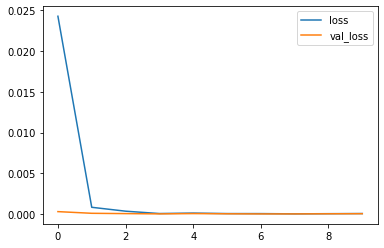

In [35]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot();

## Predictions

In [40]:
predictions = np.zeros([len(scaled_test),1])
first_batch = scaled_train[-batch_length:]
print(f"{first_batch.shape=}")
new_batch = first_batch[None, :]
print(f"{new_batch.shape=}")

for i, _ in enumerate(df_test.values):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0]
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis = 1)

y_pred = scaler.inverse_transform(predictions)
y_pred[:3]

first_batch.shape=(128, 1)
new_batch.shape=(1, 128, 1)


(array([[-1.78523921],
        [-1.93905982],
        [-2.08019471]]),
 array([], shape=(0, 1), dtype=float64))

In [42]:
df_test.head(3)

,f(x)
30.060120,-1.766205
30.160321,-1.913366
30.260521,-2.044668


<AxesSubplot:>

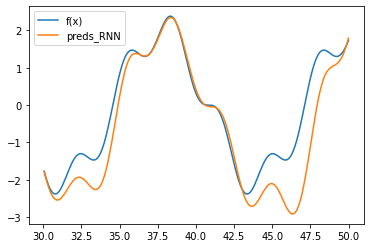

In [43]:
df_test.insert(df_test.shape[1], "preds_RNN", y_pred)
df_test.plot()

<AxesSubplot:>

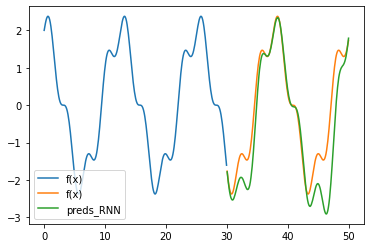

In [45]:
ax = df_train.plot()
df_test.plot(ax=ax)

## Forecasting

- predicting into the unknown future
- train on all data

In [46]:
from tensorflow.keras.layers import LSTM

LSTM_layer = LSTM(batch_length, return_sequences = False, input_shape = (None, 1))
model = RNN_model(LSTM_layer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [47]:
scaler = MinMaxScaler()
all_data = scaler.fit_transform(df)
all_data_generator = TimeseriesGenerator(
    all_data, all_data, length=batch_length, batch_size=batch_size)

model.fit(all_data_generator, epochs = 10)

Epoch 1/10
372/372 [==============================] - 21s 14ms/step - loss: 0.0093
Epoch 2/10
372/372 [==============================] - 5s 13ms/step - loss: 0.0011
Epoch 3/10
372/372 [==============================] - 5s 13ms/step - loss: 3.2381e-04
Epoch 4/10
372/372 [==============================] - 5s 14ms/step - loss: 7.3810e-05
Epoch 5/10
372/372 [==============================] - 5s 14ms/step - loss: 1.1527e-05
Epoch 6/10
372/372 [==============================] - 5s 14ms/step - loss: 1.4360e-05
Epoch 7/10
372/372 [==============================] - 5s 14ms/step - loss: 2.2234e-05
Epoch 8/10
372/372 [==============================] - 5s 14ms/step - loss: 4.9308e-05
Epoch 9/10
372/372 [==============================] - 5s 13ms/step - loss: 0.0014
Epoch 10/10
372/372 [==============================] - 5s 14ms/step - loss: 2.3897e-04


In [55]:
steps_in_future = 200

predictions = np.zeros([steps_in_future,1])
first_batch = all_data[-batch_length:]
new_batch = first_batch[None, :]

for i in range(steps_in_future):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0]
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis = 1)

y_pred = scaler.inverse_transform(predictions)

In [56]:
x_future = np.linspace(50.1, 50.1 + steps_in_future*.1, num = steps_in_future)
df_forecast = pd.DataFrame(y_pred, columns = ["Forecast"], index = x_future)
df_forecast.head()

,Forecast
50.100000,1.794770
50.200503,1.888777
50.301005,1.959970
50.401508,2.016374
50.502010,2.061293


<AxesSubplot:>

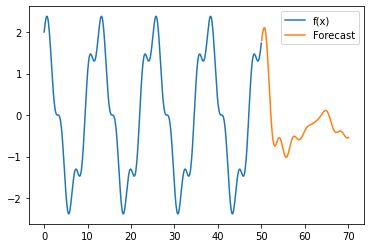

In [57]:
ax = df.plot()
df_forecast.plot(ax = ax)

<AxesSubplot:>

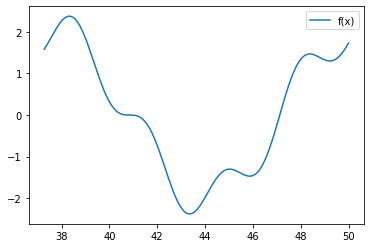

In [59]:
df.iloc[-batch_length:].plot()